### Testing the satellite code in _luseepy_

* Import prerequisites



In [1]:
import  numpy as np
import  matplotlib.pyplot as plt
import  h5py
import  lunarsky 
import  os
import  sys 
from    lunarsky.time   import Time
import datetime
import numpy.ma as ma


from astropy.time import Time as myT
print(f'''lunarsky path: {lunarsky.__path__[0]}''')


lunarsky path: /usr/local/lib/python3.10/site-packages/lunarsky


In [2]:
correct_lusee_path = '/user/luseepy/luseepy_maxim/luseepy/'
#print(f'Correct lusee path: {correct_lusee_path}')
sys.path.insert(0, correct_lusee_path) 
#print(sys.path)
import  lusee
from    lusee import Observation, Satellite, ObservedSatellite
print(f'''lusee path: {lusee.__path__[0]}''')

lusee path: /user/luseepy/luseepy_maxim/luseepy/lusee


In [3]:
# Optional: if you need to read prefab data on the satellite orbit, do it here for testing

sat_file    = h5py.File('orbital_model.hdf5')
ds_data     = sat_file["/data/trajectory"]
sat_data    = np.array(ds_data[:]) # data array

times       = sat_data[:, 0]
traj        = sat_data[:, [18,19,20]]

print(times.shape)
print(traj.shape)

N = times.shape[0]


mjd = np.empty(N, dtype=myT)
for i in range(N):
   mjd[i] = Time(times[i], format='mjd')


mask = myT('2026-01-06',format='iso')
mask_mjd = mask.mjd
print('Masking the time array at time= ',mask_mjd)
mask_mjd = Time(mask_mjd, format='mjd')

mask_array = mjd >= mask_mjd
#print(mask_array)

index = np.where(mask_array)[0]
print('Indices where masking begins',index[:3])
print('BEFORE masking:', mjd.shape, traj.shape)

mjd_filter = mjd[index]
traj_filter = traj[index]

print('CURRENTLY masking at index', index[0],' which is value', mjd_filter[0],'and 3d values: ', traj_filter[0])
print('AFTER masking:', mjd_filter.shape, traj_filter.shape)

#f = lambda x: Time(x, format='mjd')
#mjd = np.array(f(times))

time_len = (times[-1]-times[0])
mask_time_len = (times[-1]-times[min(index)])

deltaT = (times[32]-times[31])*(24*3600)

print(f'Entire data is (in days): {time_len}')
print(f'Masked data is (in days): {mask_time_len}')
print(f'deltaT_sec: {deltaT}')

(86002,)
(86002, 3)
Masking the time array at time=  61046.0
Indices where masking begins [49916 49917 49918]
BEFORE masking: (86002,) (86002, 3)
CURRENTLY masking at index 49916  which is value 61046.00037945602 and 3d values:  [-2616.635415  2558.677689  -727.693903]
AFTER masking: (36086,) (36086, 3)
Entire data is (in days): 59.72255787037284
Masked data is (in days): 25.058671469909314
deltaT_sec: 60.00000019557774


In [4]:
obs     = Observation(time_range=mjd_filter, deltaT_sec=float(deltaT))

# obs     = Observation(time_range=interval, deltaT_sec=15*60)
S       = traj_filter # Satellite()
#print(S)
obsat   = ObservedSatellite(obs, S)



time range is a numpy array
[<Time object: scale='utc' format='mjd' value=61046.00037945602>
 <Time object: scale='utc' format='mjd' value=61046.001073900465>
 <Time object: scale='utc' format='mjd' value=61046.001768344904> ...
 <Time object: scale='utc' format='mjd' value=61071.058018344906>
 <Time object: scale='utc' format='mjd' value=61071.05871278935>
 <Time object: scale='utc' format='mjd' value=61071.05905092593>]


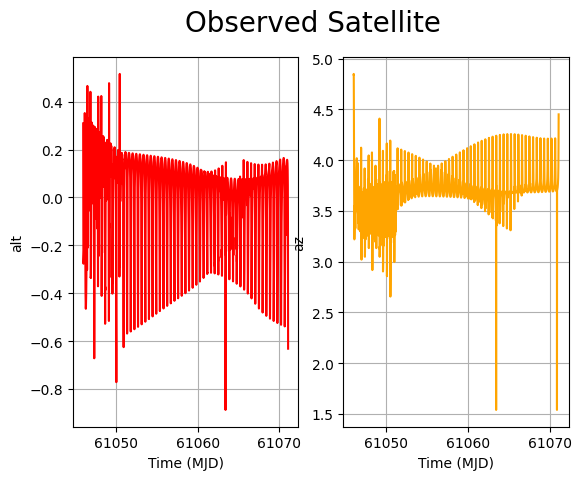

In [5]:
fig, (p1, p2) = plt.subplots(1,2)
fig.suptitle('Observed Satellite', fontsize=20)
plt.rcParams["figure.figsize"] = [20., 8.]
plt.rcParams["figure.autolayout"] = True

p1.grid(True)
p2.grid(True)

p1.set_xlabel('Time (MJD)')
p1.set_ylabel('alt')

p2.set_xlabel('Time (MJD)')
p2.set_ylabel('az')

_ = p1.plot(obsat.mjd, obsat.alt,  color="red", label="Satellite")
_ = p2.plot(obsat.mjd, obsat.az,   color="orange", label="Satellite")

# Flyover plots


In [6]:
time_cut =3000
time_cut_init = 0 # 347

In [7]:
time_1 = myT(obsat.mjd[time_cut], format='mjd') ## 1537
datetime_value_1 = time_1.to_datetime()
time_2 = myT(obsat.mjd[time_cut_init], format='mjd')
datetime_value_2 = time_2.to_datetime()
print('Orbital period (beginning to end):', datetime_value_1-datetime_value_2)
sinasinz = np.sin(obsat.alt)*np.sin(obsat.az)
sinacosz = np.sin(obsat.alt)*np.cos(obsat.az)


alt = 0
mask_alt = obsat.alt >= alt
index = np.where(mask_alt)[0]
print('Indices where masking begins',index[:3])
alt_filter = obsat.alt[index]
az_filter = obsat.az[index]

x_abov_zero = np.sin(alt_filter)*np.sin(az_filter)
y_abov_zero = np.sin(alt_filter)*np.cos(az_filter)

Orbital period (beginning to end): 2 days, 2:00:00
Indices where masking begins [0 1 2]


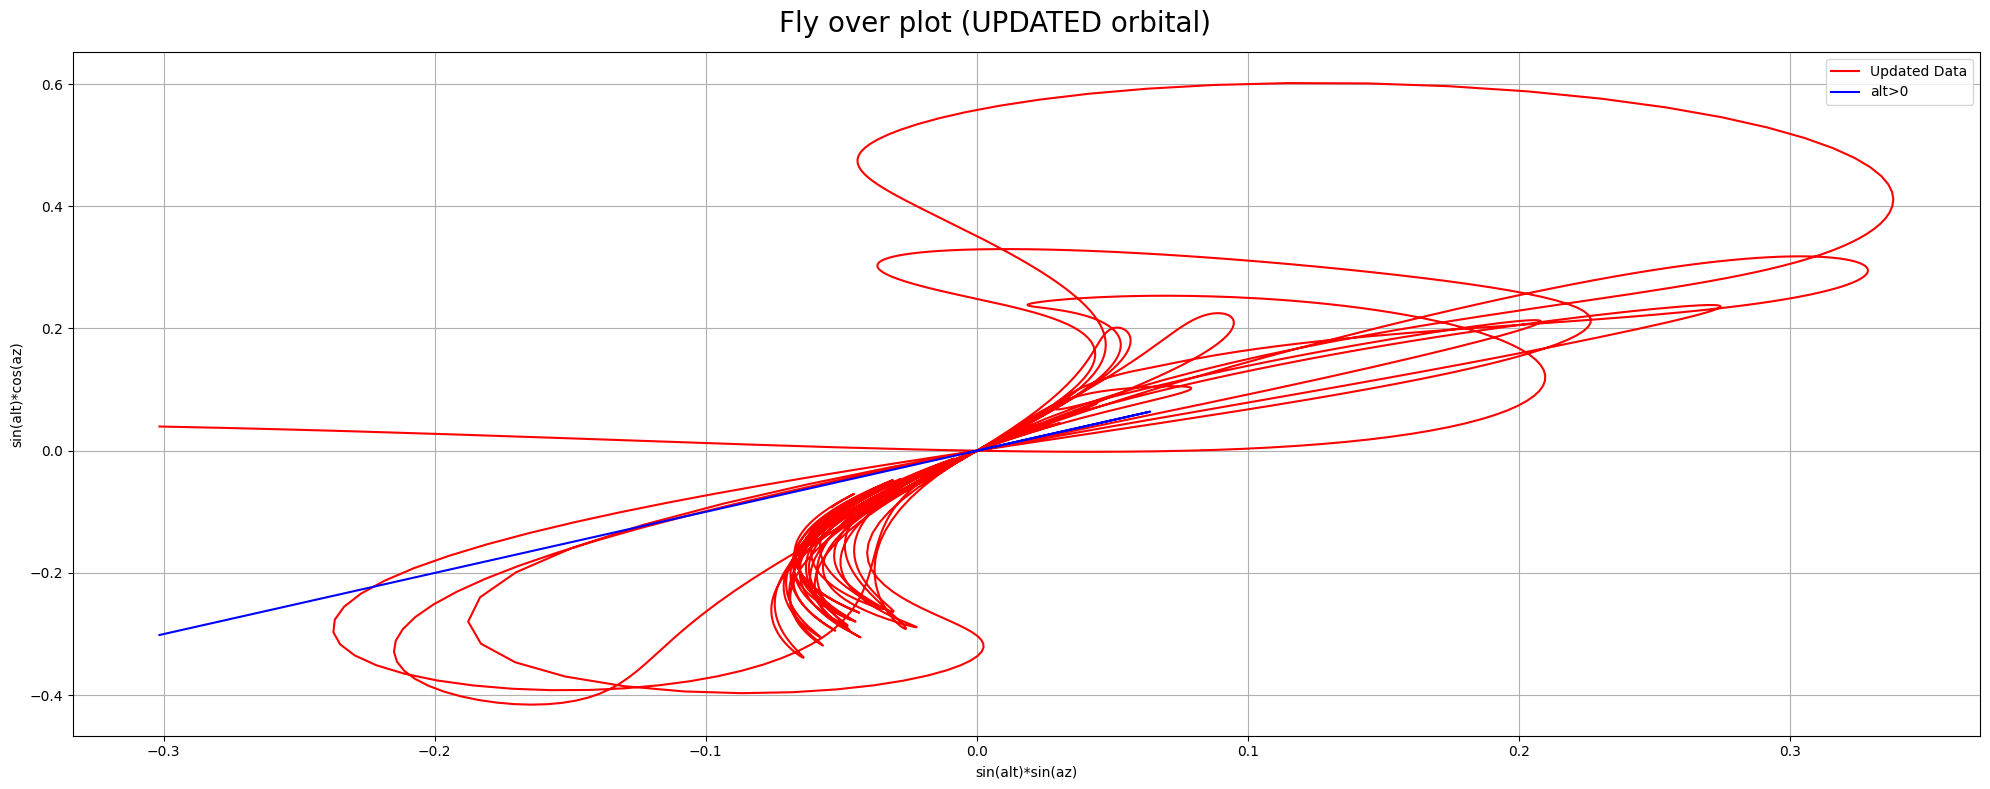

In [8]:
fig, (p1) = plt.subplots(1,1)
fig.suptitle('Fly over plot (UPDATED orbital)', fontsize=20)
plt.rcParams["figure.figsize"] = [20., 8.]
plt.rcParams["figure.autolayout"] = True

p1.grid(True)

p1.set_xlabel('sin(alt)*sin(az)')
p1.set_ylabel('sin(alt)*cos(az)')


_ = p1.plot(sinasinz[time_cut_init:time_cut], sinacosz[time_cut_init:time_cut],  color="red", label="Updated Data")
_ = p1.plot(x_abov_zero,x_abov_zero,color="blue",label='alt>0')
plt.legend()

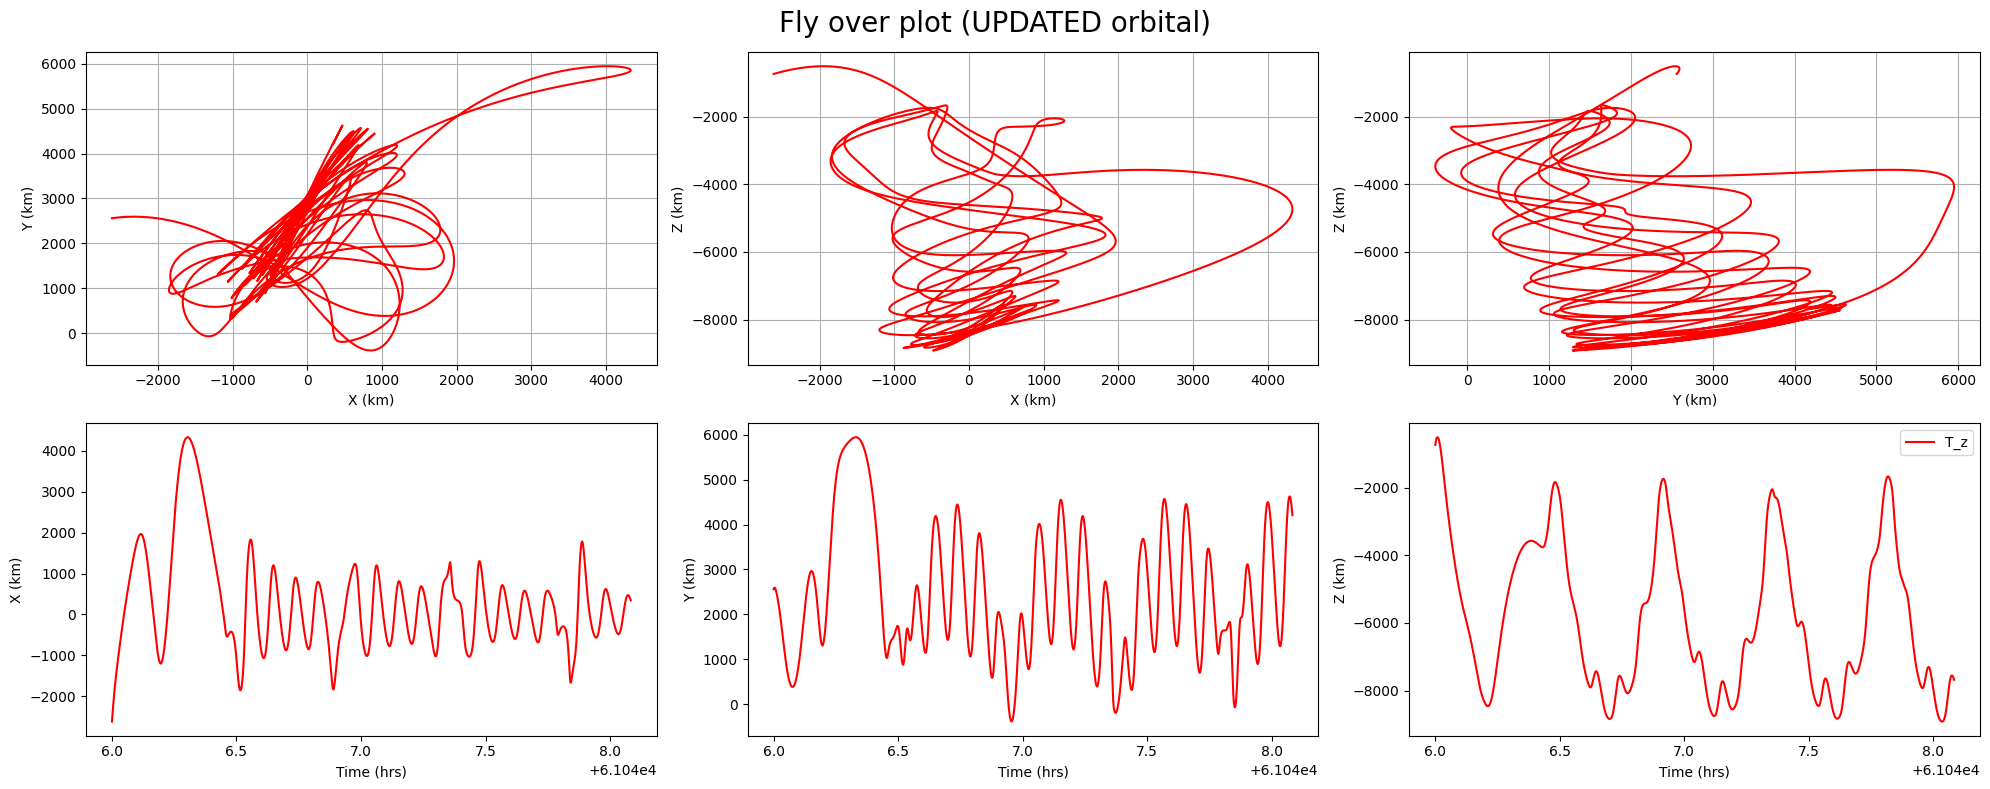

In [9]:
fig, ([p1,p2,p3],[p4,p5,p6]) = plt.subplots(2,3)
fig.suptitle('Fly over plot (UPDATED orbital)', fontsize=20)
plt.rcParams["figure.figsize"] = [20., 8.]
plt.rcParams["figure.autolayout"] = True


#p1=plt.subplot()
p1.grid(True)
p2.grid(True)
p3.grid(True)

p1.set_xlabel('X (km)')
p1.set_ylabel('Y (km)')

p2.set_xlabel('X (km)')
p2.set_ylabel('Z (km)')

p3.set_xlabel('Y (km)')
p3.set_ylabel('Z (km)')

p4.set_xlabel('Time (hrs)')
p4.set_ylabel('X (km)')

p5.set_xlabel('Time (hrs)')
p5.set_ylabel('Y (km)')

p6.set_xlabel('Time (hrs)')
p6.set_ylabel('Z (km)')


_ = p1.plot(obsat.posxyz[:time_cut,0],obsat.posxyz[:time_cut,1], color = 'red', label = 'X-Y')
_ = p2.plot(obsat.posxyz[:time_cut,0],obsat.posxyz[:time_cut,2], color = 'red', label = 'X-Z')
_ = p3.plot(obsat.posxyz[:time_cut,1],obsat.posxyz[:time_cut,2], color = 'red', label = 'Y-Z')
_ = p4.plot(obsat.mjd[:time_cut],obsat.posxyz[:time_cut,0], color = 'red', label = 'T_X')
_ = p5.plot(obsat.mjd[:time_cut],obsat.posxyz[:time_cut,1], color = 'red', label = 'T_y')
_ = p6.plot(obsat.mjd[:time_cut],obsat.posxyz[:time_cut,2], color = 'red', label = 'T_z')
plt.legend()

# Plot tracks

Text(0, 0.5, 'N-S')

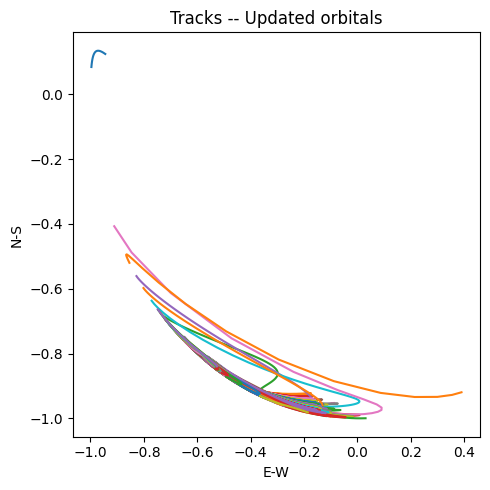

In [10]:
plt.figure(figsize=(5,5))
obsat.plot_tracks(plt)
plt.title('Tracks -- Updated orbitals')
plt.xlabel("E-W")
plt.ylabel("N-S")

In [11]:
transits = obsat.get_transit_indices()
print (len(transits))

75


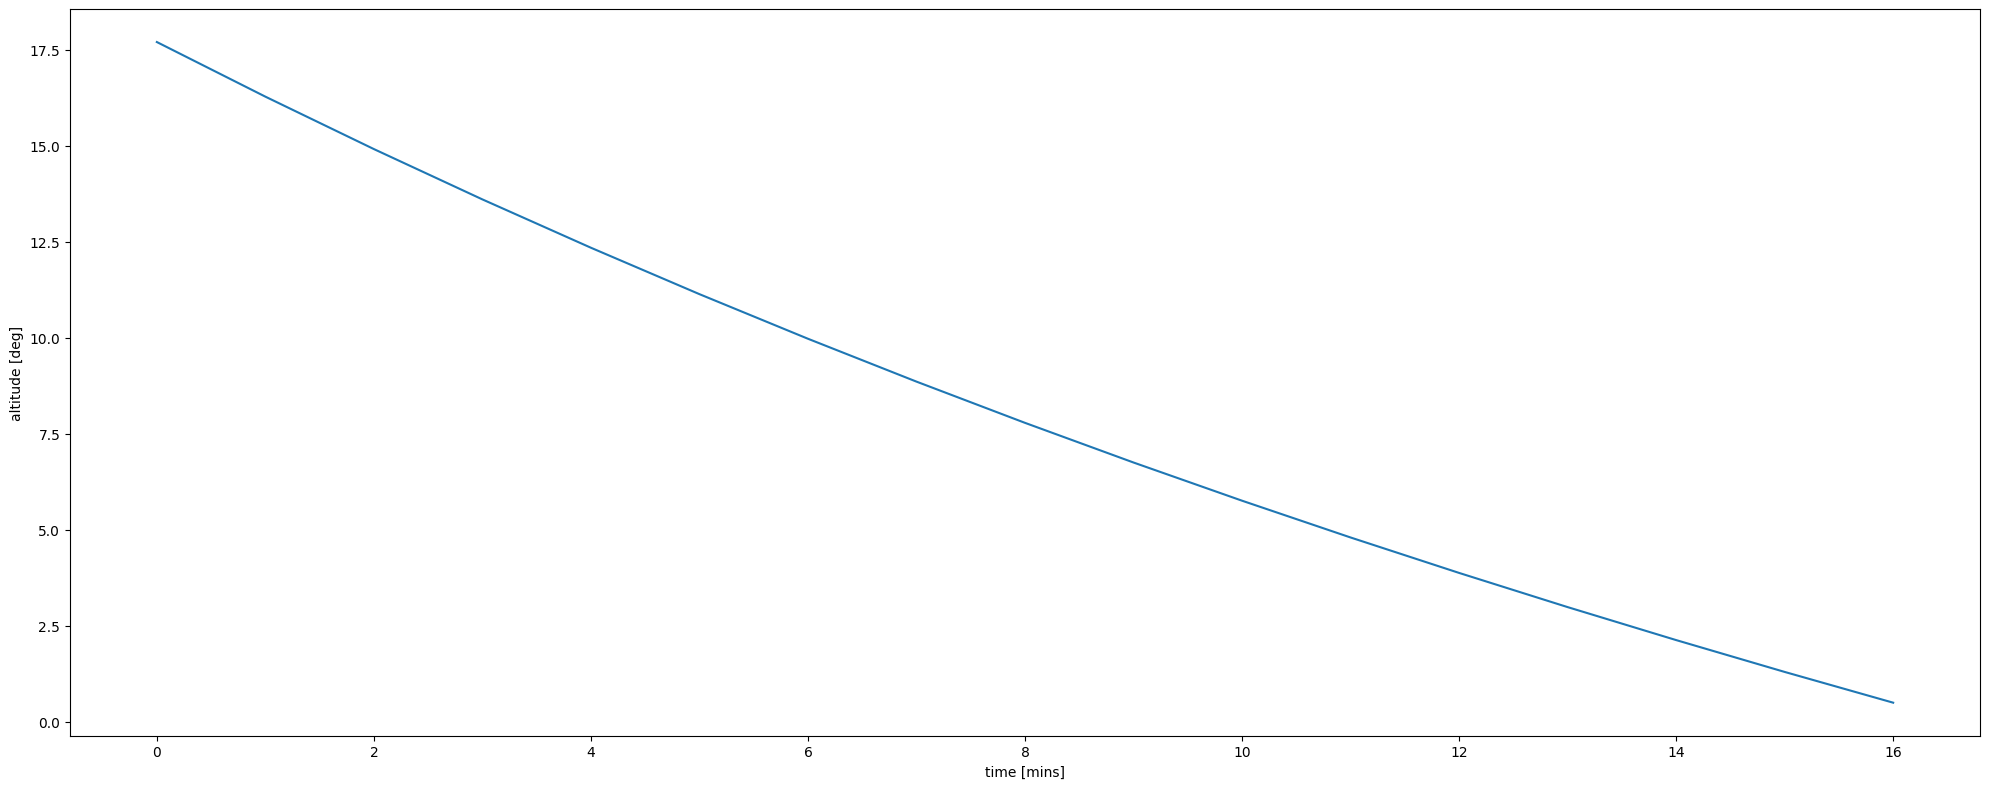

In [12]:
# Take transit #5
i,j = transits[0]
plt.plot(np.arange(j-i),obsat.alt_rad()[i:j]/np.pi*180)
plt.xlabel('time [mins]')
plt.ylabel('altitude [deg]')
pass

---

### Plot the trajectory

Test plot with canonical settings, for back reference.


[<Time object: scale='utc' format='datetime' value=2025-01-29 03:34:26.048641>
 <Time object: scale='utc' format='datetime' value=2025-01-29 03:35:26.048641>
 <Time object: scale='utc' format='datetime' value=2025-01-29 03:36:26.048641>
 ...
 <Time object: scale='utc' format='datetime' value=2025-02-27 17:43:26.048641>
 <Time object: scale='utc' format='datetime' value=2025-02-27 17:44:26.048641>
 <Time object: scale='utc' format='datetime' value=2025-02-27 17:45:26.048641>]
29 days, 14:11:00
-5471.439120712272 2686.0471045064905
x distance difference -8157.486225218762
y distance difference -1418.0826750784838


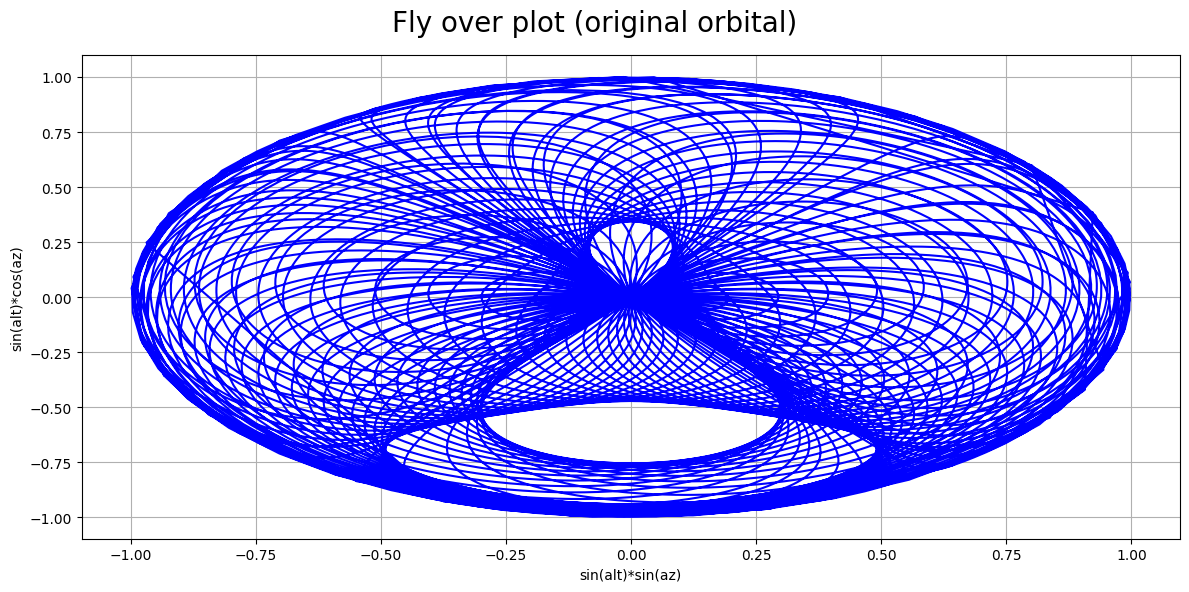

In [13]:
obs     = Observation(deltaT_sec=60)
S       = Satellite()
obsat   = ObservedSatellite(obs, S)

# fig, (p1, p2) = plt.subplots(1,2)

#fig.suptitle('Simulation', fontsize=20)
plt.rcParams["figure.figsize"] = [12., 6.]
#plt.rcParams["figure.autolayout"] = True
fig, (p1) = plt.subplots(1,1)
fig.suptitle('Fly over plot (original orbital)', fontsize=20)
plt.rcParams["figure.figsize"] = [20., 8.]
plt.rcParams["figure.autolayout"] = True


#p1=plt.subplot()
p1.grid(True)
#p2.grid(True)

#p1.set_xlim([60715,60730])
#p2.set_xlim([60715,60730])

#p1.set_xlim([61012,61015])
#p2.set_xlim([61012,61015])

p1.set_xlabel('sin(alt)*sin(az)')
p1.set_ylabel('sin(alt)*cos(az)')



#ax = fig.add_subplot(1, 2, 1, projection='3d')

#ax.plot3D(obsat.posxyz[:2000,0], obsat.posxyz[:2000,1], obsat.posxyz[:2000,2])
#ax.scatter3D(obsat.posxyz[:2000:20,0], obsat.posxyz[:2000:20,1], obsat.posxyz[:2000:20,2])
#_ = ax.scatter3D(0,0,0)


#beg_las = obsat.mjd[1500]-obsat.mjd[0]


# Convert MJD to datetime
time_1 = myT(obsat.mjd[-1], format='mjd') ## 523
datetime_value_1 = time_1.to_datetime()
time_2 = myT(obsat.mjd[0], format='mjd')
datetime_value_2 = time_2.to_datetime()
print(datetime_value_1-datetime_value_2)

print(obsat.posxyz[0,0],obsat.posxyz[523,0] )
print('x distance difference', obsat.posxyz[0,0]-obsat.posxyz[523,0] )
print('y distance difference', obsat.posxyz[0,1]-obsat.posxyz[523,1] )

_ = p1.plot(np.sin(obsat.alt)*np.sin(obsat.az), np.sin(obsat.alt)*np.cos(obsat.az),  color="blue", label="Updated Data")
#_ = p2.plot(obsat.posxyz[:523,0],obsat.posxyz[:523,1],   color="orange", label="Original Data")
plt.show()

In [14]:
# ---- just keep for later
# fig     = plt.figure(figsize=(20,10))
# plt.rcParams["figure.autolayout"] = True
# ax      = plt.axes(projection='3d')
# posxyz  = obsat.posxyz

# ax.plot3D(posxyz[:2000,0],posxyz[:2000,1],posxyz[:2000,2])
# ax.scatter3D(posxyz[:2000:20,0],posxyz[:2000:20,1],posxyz[:2000:20,2])
# _ = ax.scatter3D(0,0,0)

# ax = fig.add_subplot(1, 2, 2)
# obsat.plot_tracks(ax)
# plt.show()


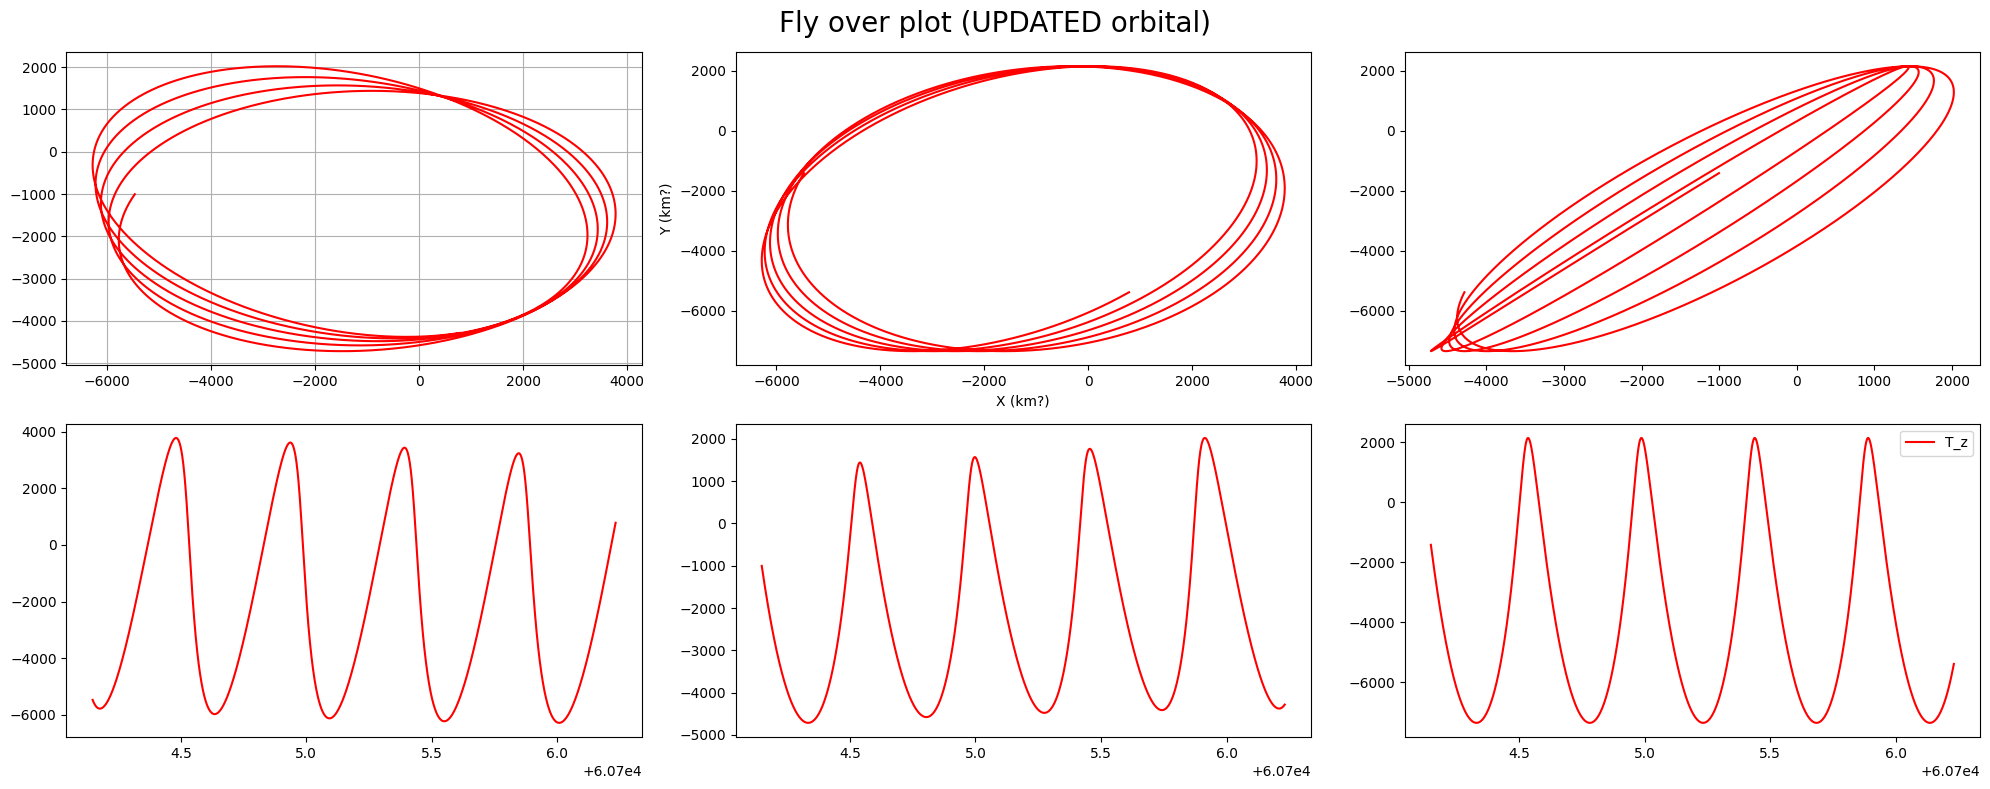

In [15]:
fig, ([p1,p2,p3],[p4,p5,p6]) = plt.subplots(2,3)
fig.suptitle('Fly over plot (UPDATED orbital)', fontsize=20)
plt.rcParams["figure.figsize"] = [20., 8.]
plt.rcParams["figure.autolayout"] = True

p1.grid(True)

p2.set_xlabel('X (km?)')
p2.set_ylabel('Y (km?)')


_ = p1.plot(obsat.posxyz[:time_cut,0],obsat.posxyz[:time_cut,1], color = 'red', label = 'X-Y')
_ = p2.plot(obsat.posxyz[:time_cut,0],obsat.posxyz[:time_cut,2], color = 'red', label = 'X-Z')
_ = p3.plot(obsat.posxyz[:time_cut,1],obsat.posxyz[:time_cut,2], color = 'red', label = 'Y-Z')
_ = p4.plot(obsat.mjd[:time_cut],obsat.posxyz[:time_cut,0], color = 'red', label = 'T_X')
_ = p5.plot(obsat.mjd[:time_cut],obsat.posxyz[:time_cut,1], color = 'red', label = 'T_y')
_ = p6.plot(obsat.mjd[:time_cut],obsat.posxyz[:time_cut,2], color = 'red', label = 'T_z')
plt.legend()

Text(0, 0.5, 'N-S')

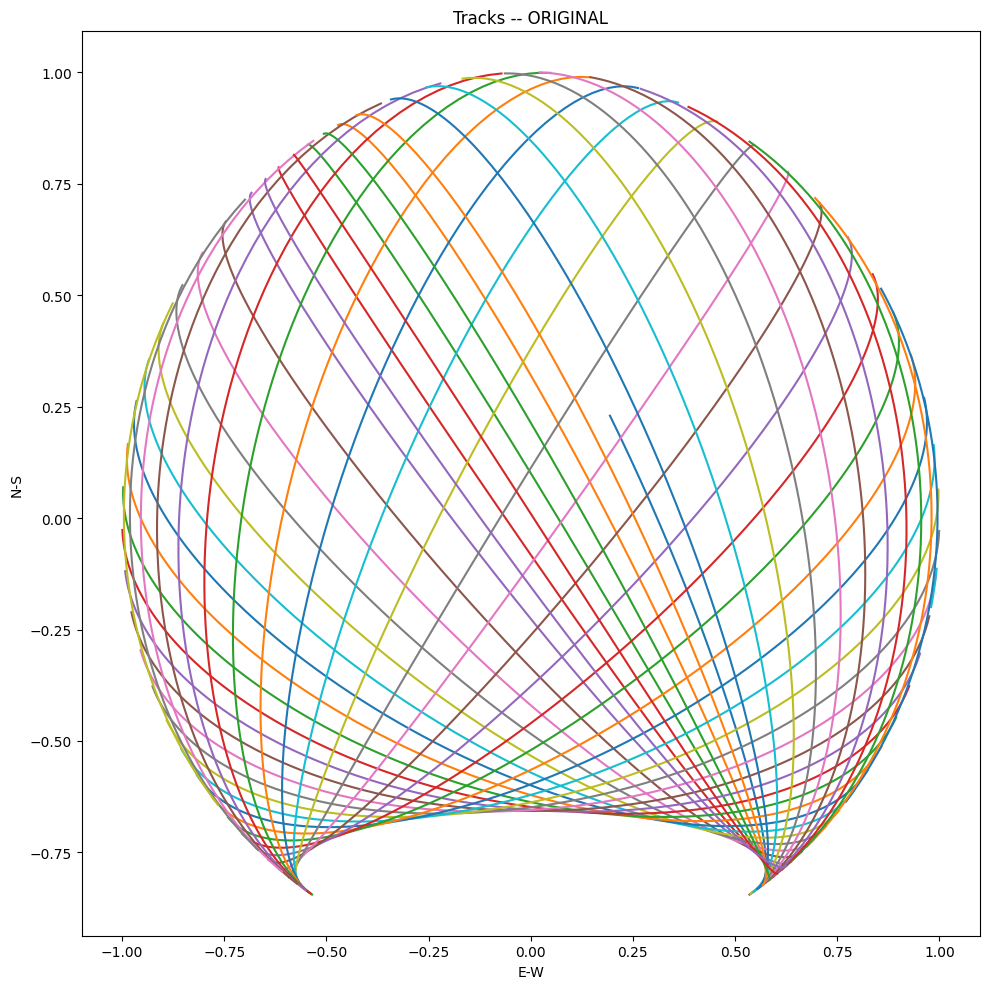

In [16]:
plt.figure(figsize=(10,10))
obsat.plot_tracks(plt)
plt.title('Tracks -- ORIGINAL')
plt.xlabel("E-W")
plt.ylabel("N-S")

In [17]:
transits = obsat.get_transit_indices()
print (len(transits))

55


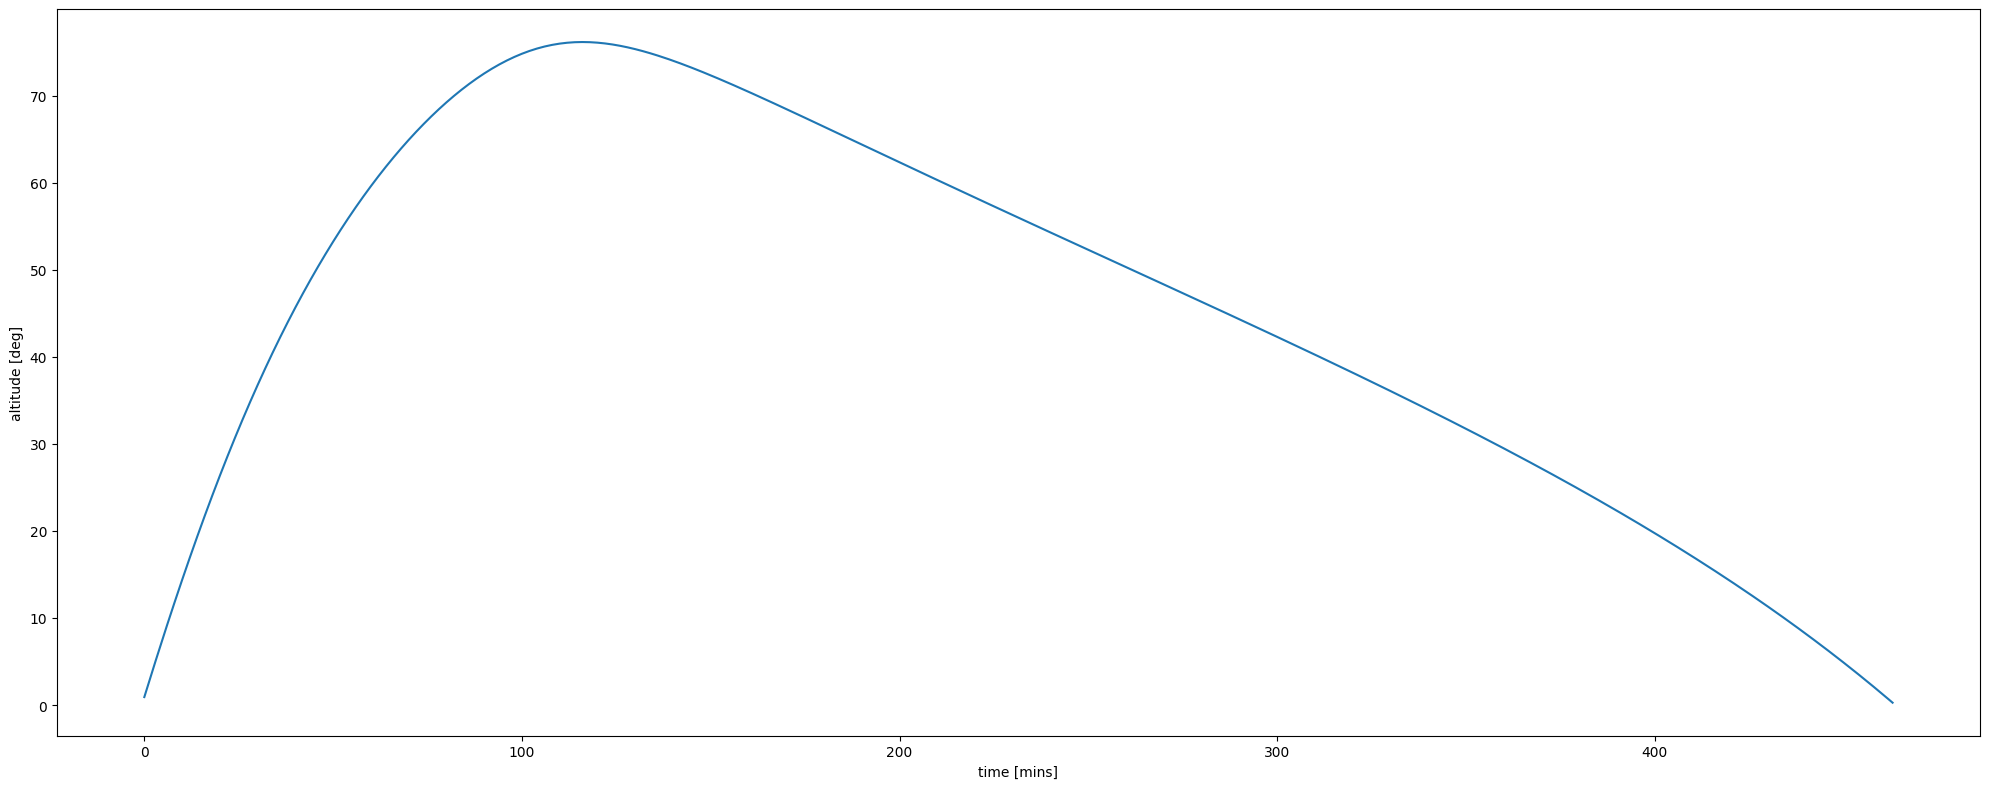

In [18]:
# Take transit #5
i,j = transits[5]
plt.plot(np.arange(j-i),obsat.alt_rad()[i:j]/np.pi*180)
plt.xlabel('time [mins]')
plt.ylabel('altitude [deg]')
pass